# Applinces Reviews Model

## 1. Basic Imports Lib & Modules

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Load Data & Basic Cleaning

In [2]:
df = pd.read_csv("Appliances_Reviews.csv")

df['sentiment'] = df['overall'].apply(lambda x: 1 if x > 3 else 0)
df['text'] = df['reviewText'].fillna('') + " " + df['summary'].fillna('')
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text

df['text'] = df['text'].apply(clean_text)

## 3. split

In [3]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'].tolist(),df['sentiment'].tolist(),test_size=0.1,random_state=42)

## 4. Dataset Training & Loader

In [4]:
MAX_VOCAB = 30000
MAX_LEN = 120
counter = Counter()
for text in train_texts:
    counter.update(text.split())
vocab = ["<pad>", "<unk>"] + [w for w, _ in counter.most_common(MAX_VOCAB)]
word2idx = {w:i for i,w in enumerate(vocab)}

def encode(text):
    tokens = text.split()
    ids = [word2idx.get(t,1) for t in tokens][:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [0]*(MAX_LEN-len(ids))
    return ids

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):

        x = torch.tensor(encode(self.texts[idx]))
        y = torch.tensor(self.labels[idx])

        return x, y
train_dataset = ReviewDataset(train_texts, train_labels)
val_dataset = ReviewDataset(val_texts, val_labels)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

## 5. Model

In [5]:
class FastBiLSTM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 128)
        self.lstm = nn.LSTM(128,128,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1]
        out = self.dropout(out)
        return self.fc(out)
model = FastBiLSTM(len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## 6. Training Loop

In [6]:
def train_epoch():
    model.train()
    preds = []
    labels_all = []
    losses = []
    for x, y in tqdm(train_loader):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        outputs = model(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()
        preds.extend(torch.argmax(outputs,1).cpu().numpy())
        labels_all.extend(y.cpu().numpy())
        losses.append(loss.item())

    acc = accuracy_score(labels_all, preds)
    return np.mean(losses), acc

## 7. BiLSTM Model

In [7]:
def evaluate():
    model.eval()
    preds = []
    labels_all = []
    losses = []

    with torch.no_grad():

        for x, y in val_loader:

            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            preds.extend(torch.argmax(outputs,1).cpu().numpy())
            labels_all.extend(y.cpu().numpy())
            losses.append(loss.item())
    acc = accuracy_score(labels_all, preds)
    return np.mean(losses), acc

## 8. Training Loop

In [8]:
EPOCHS = 3
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = evaluate()

100%|██████████| 2120/2120 [00:57<00:00, 37.19it/s]


## 9. Evalution

In [9]:
model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():

    for batch in val_loader:

        if isinstance(batch, dict):  # Transformer models
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, mask)

        else:  # LSTM / CNN
            x, labels = batch
            x = x.to(device)
            labels = labels.to(device)

            outputs = model(x)

        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     11065
           1       0.97      0.98      0.97     49213

    accuracy                           0.96     60278
   macro avg       0.93      0.92      0.92     60278
weighted avg       0.95      0.96      0.95     60278



## 10. HeatMap

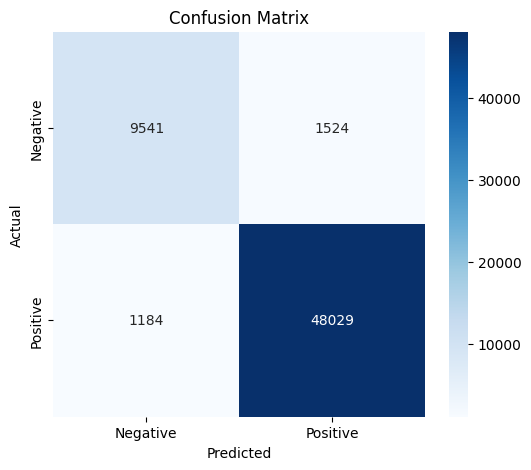

In [10]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=["Negative","Positive"],yticklabels=["Negative","Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()